In [53]:
import sys
import json
import numpy as np
params = {}
default = {'training_folder': '../../scenarios/dallas/', 'params': params} # Default execution parameters
manual, argv = (True, default) if 'ipykernel' in sys.argv[0] else (False, dict(default, **json.loads(sys.argv[1])))
print(argv)

{'training_folder': '../../scenarios/dallas/', 'params': {}}


In [121]:
import os
import time
import geopandas as gpd
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
sys.path.insert(0, r'../../../quetzal') # Add path to quetzal
from sklearn.neighbors import NearestNeighbors
from numba import jit, njit
import numba as nb
from quetzal.model import stepmodel
from shapely.geometry import LineString
from quetzal.io.gtfs_reader.importer import get_epsg
from quetzal.io import excel
from syspy.skims.skims import euclidean
on_lambda = bool(os.environ.get('AWS_EXECUTION_ENV'))
num_cores = nb.config.NUMBA_NUM_THREADS
print('num cores:',num_cores)

io_engine= 'pyogrio' if on_lambda else 'pyogrio' #or fiona

num cores: 8


In [55]:
base_folder = argv['training_folder']
input_folder = os.path.join(base_folder,'inputs/')
pt_folder  = os.path.join(input_folder,'pt/')
road_folder = os.path.join(input_folder,'road/')
params_folder = input_folder if on_lambda else '../../inputs/'

output_folder = os.path.join(base_folder,'outputs/')
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    
model_folder = os.path.join(base_folder, 'model/')


In [56]:
od = pd.read_csv(input_folder + 'OD.csv')
blocks_fix = gpd.read_file(input_folder + 'blocks_fix.geojson')
part_modale = gpd.read_file(input_folder + 'part_modale.geojson')

Génération

In [57]:
od['volumes'] = od[['S000', 'SA01', 'SA02', 'SA03', 'SE01','SE02', 'SE03', 'SI01', 'SI02', 'SI03']].sum(axis = 1)

In [58]:
part_modale = part_modale.loc[~part_modale['Geography'].isna()]
part_modale['County'] = part_modale['Geography'].apply(lambda x: x[11:14])
part_modale['TRACTCE20'] = part_modale['Geography'].apply(lambda x: x[-6:])

block_to_track = blocks_fix[['GEOID20', 'TRACTCE20']]

block_name_track = part_modale[['TRACTCE20', 'NAME', 'County']].merge(block_to_track, on = 'TRACTCE20',  how = 'right')
block_name_track = block_name_track.drop_duplicates(['NAME', 'GEOID20'])

In [59]:
sm = stepmodel.read_zippedpickles(model_folder + 'distribution')
sm_network = stepmodel.read_zippedpickles(model_folder + 'network')
sm.zones =sm_network.zones
sm.zone_before_clustering.set_index('cluster', inplace= True)
sm._add_type_prefixes({'zone_before_clustering':'zone_'})
#sm.zone_before_clustering.reset_index(inplace= True)
sm.zone_before_clustering['index'] = sm.zone_before_clustering.index



zones: 100%|██████████| 26/26 [00:01<00:00, 15.80it/s]          


In [60]:
sm.volumes = sm.volumes.fillna(0)
sm.volumes['volumes'] = sm.volumes['car_owner'] + sm.volumes['pt_captive']
sm.volumes.drop_duplicates(['origin', 'destination'])

,origin,destination,car_owner,pt_captive,volumes
62477,zone_82,zone_364,1302.562670,352.155391,1654.718062
45172,zone_409,zone_364,950.300319,351.290822,1301.591141
7228,zone_144,zone_364,700.053785,326.663260,1026.717046
39425,zone_374,zone_139,750.712264,326.395053,1077.107316
30464,zone_32,zone_139,875.758912,326.036870,1201.795782
...,...,...,...,...,...
65174,zone_99,zone_81,25.165714,0.000000,25.165714
65176,zone_99,zone_83,25.038775,0.000000,25.038775
65177,zone_99,zone_86,25.025915,0.000000,25.025915
65179,zone_99,zone_88,50.182638,0.000000,50.182638


In [61]:
od_track= od.merge(block_name_track[['NAME', 'GEOID20', 'County']], left_on= 'w_geocode', right_on= 'GEOID20', how = 'left')
od_track = od_track.merge(block_name_track[['NAME', 'GEOID20', 'County']],left_on= 'h_geocode', right_on= 'GEOID20', how = 'left', suffixes= ('_origin', '_destination'))
od_track.loc[od_track['NAME_destination'].isna()]['volumes'].sum(), od_track.loc[~od_track['NAME_destination'].isna()]['volumes'].sum()
od_track = od_track.loc[~od_track['NAME_destination'].isna()][['NAME_origin', 'NAME_destination', 'volumes', 'County_origin', 'County_destination']]
od_track = od_track.merge(sm.zone_before_clustering[['index', 'NAME']], left_on=  'NAME_origin', right_on= 'NAME', how = 'left')
od_track = od_track.merge(sm.zone_before_clustering[['index', 'NAME']], left_on=  'NAME_destination', right_on= 'NAME', how = 'left' , suffixes = ('_origin', '_destination'))
od_track = od_track.drop(['NAME_origin', 'NAME_destination'], axis = 1)
od_track = od_track.groupby(['index_origin', 'index_destination', 'County_origin', 'County_destination'], as_index=False).sum()
od_track.rename(columns={'index_origin': 'origin', 'index_destination': 'destination'}, inplace = True)
od_track.drop_duplicates(['origin', 'destination'])


,origin,destination,County_origin,County_destination,volumes
0,zone_0,zone_0,085,085,1116
1,zone_0,zone_1,085,439,52
2,zone_0,zone_10,085,085,288
3,zone_0,zone_100,085,439,52
4,zone_0,zone_101,085,121,304
...,...,...,...,...,...
113149,zone_99,zone_91,439,439,32
113150,zone_99,zone_95,439,439,16
113151,zone_99,zone_96,439,113,8
113152,zone_99,zone_97,439,113,8


In [66]:
part_modale['County'].unique(), block_name_track['County'].unique()

(array(['085', '113', '121', '439', '139', '231', '251', '257', '367',
        '397', '497'], dtype=object),
 array(['397', '085', '113', '497', '439', '257', '139', '121', '251', nan],
       dtype=object))

In [62]:
print(' Calibration:'+ od_track['volumes'].sum().astype(str) + '\n','Model:'+ sm.volumes['volumes'].sum().astype(str) + '\n','Rapport:' + (od_track['volumes'].sum()/sm.volumes['volumes'].sum()).astype(str) + '\n' )

 Calibration:10740200
 Model:3818017.9634162076
 Rapport:2.8130302431553007



In [67]:
comp_volumes = od_track.merge(sm.volumes[['origin', 'destination','volumes']], on = ['origin', 'destination'], how= 'inner', suffixes= ('_calibration', '_model'))

comp_volumes_macro = comp_volumes.groupby(['County_origin', 'County_destination'], as_index=False).sum()

In [68]:
def GEH(A, B):
    return ((2*(A-B)**2)/(A+B)).apply(math.sqrt)

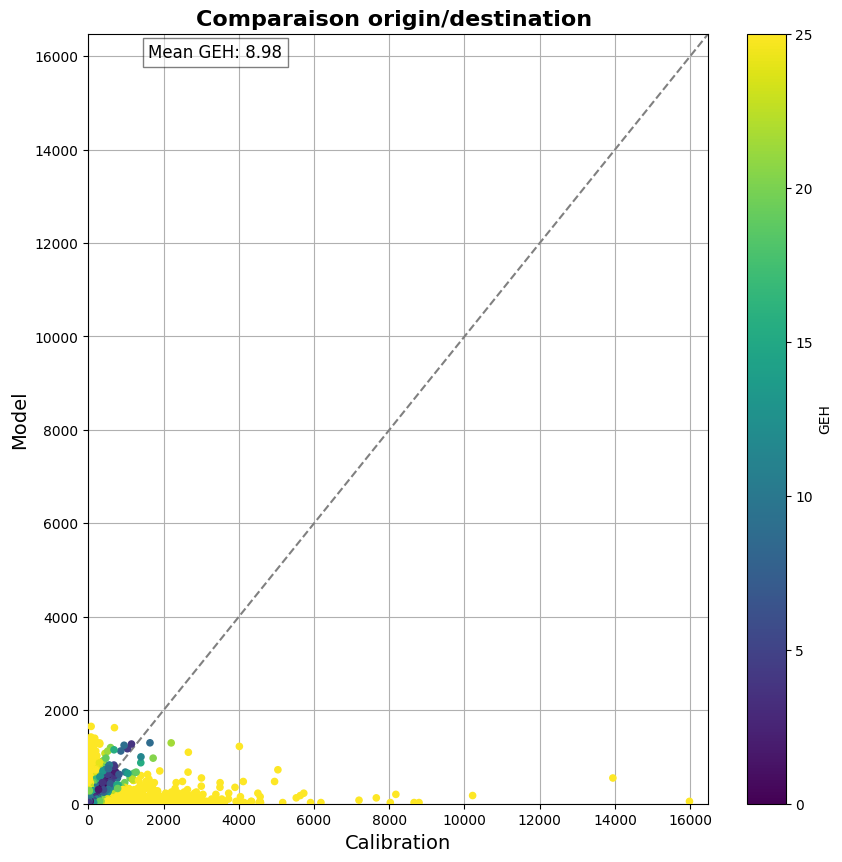

In [108]:
to_plot = comp_volumes.set_index(['origin', 'destination'])
ycol= 'volumes_model'
xcol= 'volumes_calibration'
to_plot['GEH'] = GEH(to_plot['volumes_model'], to_plot['volumes_calibration'])
ax =  to_plot.plot.scatter(x=xcol, y=ycol, c='GEH', figsize=[10, 10], zorder=3, cmap='viridis', vmin=0, vmax=25)

stats = True
if stats:
    meanGEH = to_plot['GEH'].mean()
    mvol = to_plot[['volumes_model','volumes_calibration']].max().max()
    plt.text(0.1*mvol, mvol,
                        'Mean GEH: {e}'.format(e=np.round(meanGEH, 2)), fontsize = 12,
                        bbox = dict(facecolor = 'white', alpha = 0.5))

t = np.arange(0., max(to_plot[xcol].max(),to_plot[ycol].max()) +500, 1)
plt.plot(t,t,linestyle='--',color="Grey", zorder=2)
plt.xlim([0., max(to_plot[xcol].max(),to_plot[ycol].max())+500])
plt.ylim([0., max(to_plot[xcol].max(),to_plot[ycol].max())+500])
plt.ylabel('Model', fontsize=14)
plt.xlabel('Calibration', fontsize=14)
ax.grid(axis='both', zorder=3)
plt.title('Comparaison origin/destination ', loc='center', fontsize=16, fontweight="bold")
fig = ax.get_figure()
#fig.savefig('../../outputs/plot/%s/%s/%s.png' % (scenario+'_'+period_s,zone, 'boardings_bus'), bbox_inches='tight', dpi=150)

In [70]:
def round_up(n, decimals=0):
    multiplier = 10**decimals
    return math.ceil(n * multiplier) / multiplier

In [72]:
origins = sm.volumes['origin'].unique().tolist()
destinations = sm.volumes['destination'].unique().tolist()

distances = euclidean(sm.zones, coordinates_unit='meter', epsg=4326, origins=origins, destinations=destinations)
distances['euclidean_distance'] = (distances['euclidean_distance']/1000).apply(lambda x: round_up(x,-1))
distances = distances[['origin', 'destination', 'euclidean_distance']]


In [110]:
comp_volumes_dist= comp_volumes.merge(distances, on = ['origin','destination'] , how= 'left' )
comp_volumes_dist = comp_volumes_dist.groupby('euclidean_distance')['volumes_calibration', 'volumes_model'].sum()


In [ ]:
 
# Heights of bars in two bar diagrams
A = [3, 1, 4]
B = [2, 2, 3]
 
# Calculate the Wasserstein distance

distance = wasserstein_distance(A, B)

print("Wasserstein Distance:", distance)


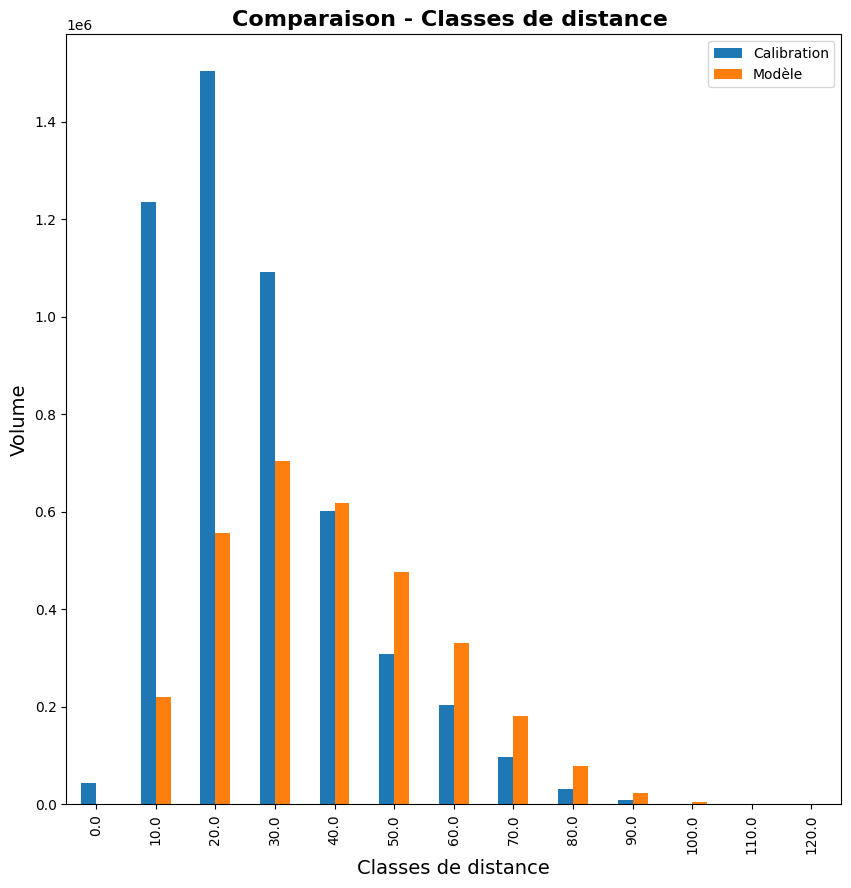

In [118]:
comp_volumes_dist.plot( kind = 'bar', figsize=[10, 10])
plt.ylabel('Volume', fontsize=14)
plt.xlabel('Classes de distance', fontsize=14)
plt.title('Comparaison - Classes de distance ', loc='center', fontsize=16, fontweight="bold")
plt.legend(['Calibration', 'Modèle'])
fig = ax.get_figure()


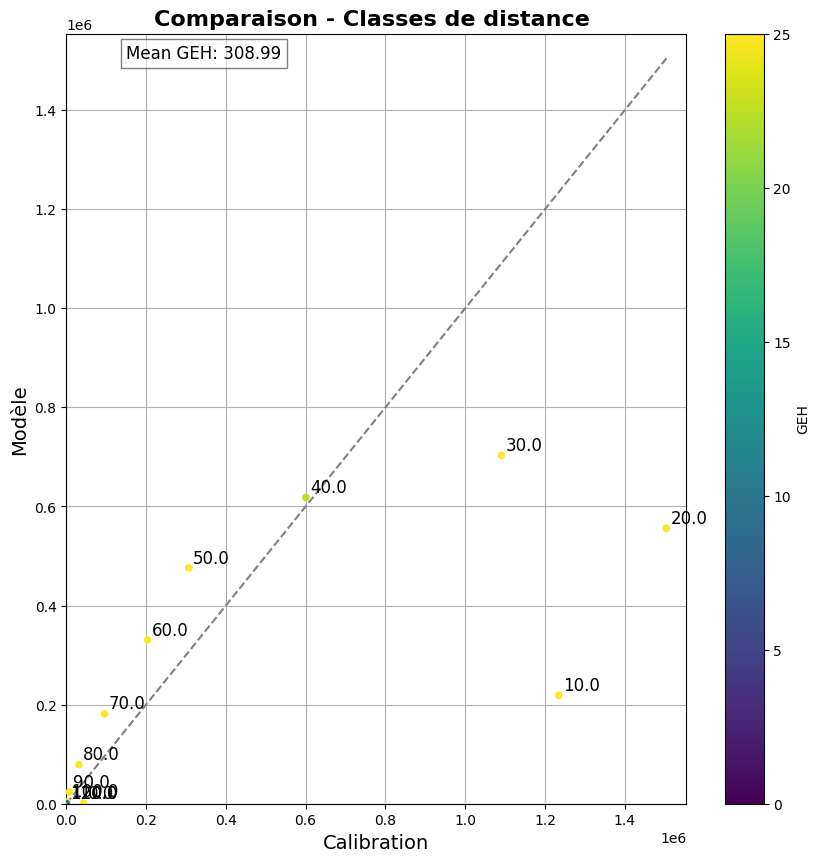

In [119]:
to_plot = comp_volumes_dist
ycol= 'volumes_model'
xcol= 'volumes_calibration'
to_plot['GEH'] = GEH(to_plot['volumes_model'], to_plot['volumes_calibration'])
ax =  to_plot.plot.scatter(x=xcol, y=ycol, c='GEH', figsize=[10, 10], zorder=3, cmap='viridis', vmin=0, vmax=25)

to_plot['label'] = to_plot.index
to_plot[['x_label','y_label']] = to_plot[[xcol,ycol]] +10000
to_plot[['x_label','y_label','label']].apply(lambda x: ax.text(*x, fontsize=12),axis=1)

stats = True
if stats:
    meanGEH = to_plot['GEH'].mean()
    mvol = to_plot[['volumes_model','volumes_calibration']].max().max()
    plt.text(0.1*mvol, mvol,
                        'Mean GEH: {e}'.format(e=np.round(meanGEH, 2)), fontsize = 12,
                        bbox = dict(facecolor = 'white', alpha = 0.5))

t = np.arange(0., max(to_plot[xcol].max(),to_plot[ycol].max()) +500, 1)
plt.plot(t,t,linestyle='--',color="Grey", zorder=2)
plt.xlim([0., max(to_plot[xcol].max(),to_plot[ycol].max())+50000])
plt.ylim([0., max(to_plot[xcol].max(),to_plot[ycol].max())+50000])
plt.ylabel('Modèle', fontsize=14)
plt.xlabel('Calibration', fontsize=14)
ax.grid(axis='both', zorder=3)
plt.title('Comparaison - Classes de distance ', loc='center', fontsize=16, fontweight="bold")
fig = ax.get_figure()
#fig.savefig('../../outputs/plot/%s/%s/%s.png' % (scenario+'_'+period_s,zone, 'boardings_bus'), bbox_inches='tight', dpi=150)

In [92]:
#TODO histogramme avec indicateur de dispersion (earth mover distance)

,County_origin,County_destination,volumes_calibration,volumes_model
0,085,085,302100,83977.394457
1,085,113,239644,299086.856851
2,085,121,96256,54291.536710
3,085,139,8,77.538100
4,085,251,20,201.066989
5,085,397,8,101.332930
6,085,439,54592,128125.823305
7,113,085,422496,177811.265769
8,113,113,1713484,718933.046423
9,113,121,309836,117282.214924


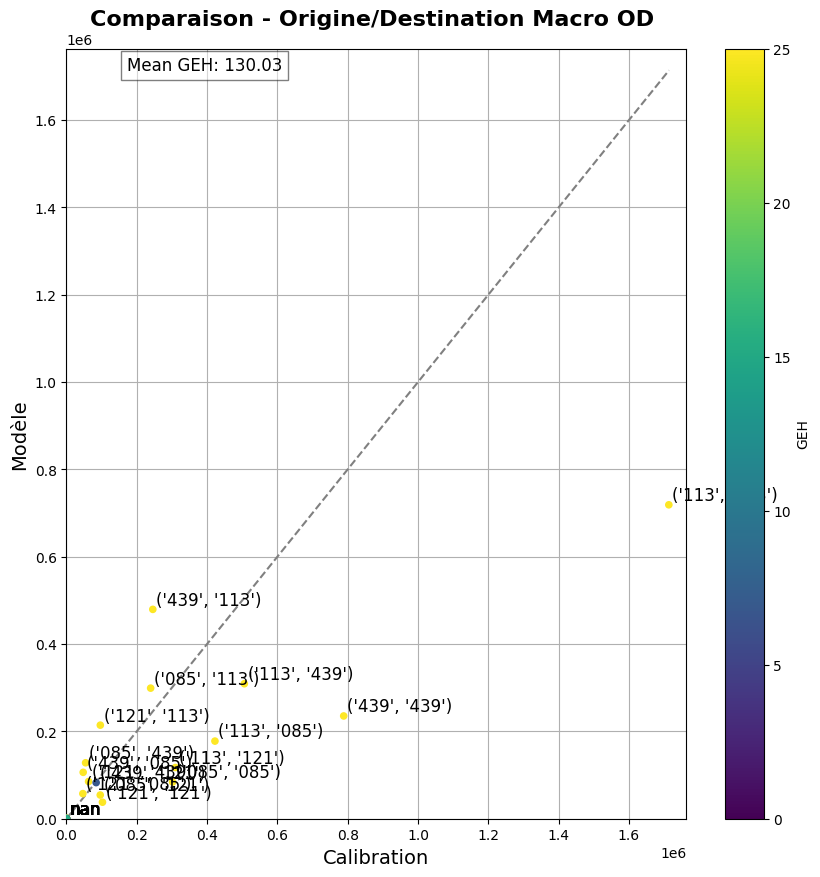

In [120]:
to_plot = comp_volumes_macro.set_index(['County_origin', 'County_destination'])
ycol= 'volumes_model'
xcol= 'volumes_calibration'
to_plot['GEH'] = GEH(to_plot['volumes_model'], to_plot['volumes_calibration'])
ax =  to_plot.plot.scatter(x=xcol, y=ycol, c='GEH', figsize=[10, 10], zorder=3, cmap='viridis', vmin=0, vmax=25)


to_plot['is_labeled'] = (abs(to_plot[xcol] -to_plot[ycol]) > 940)
to_plot.loc[to_plot['is_labeled'],'label'] = to_plot.loc[to_plot['is_labeled']].index
to_plot[['x_label','y_label']] = to_plot[[xcol,ycol]] +10000
to_plot[['x_label','y_label','label']].apply(lambda x: ax.text(*x, fontsize=12),axis=1)

stats = True
if stats:
    meanGEH = to_plot['GEH'].mean()
    mvol = to_plot[['volumes_model','volumes_calibration']].max().max()
    plt.text(0.1*mvol, mvol,
                        'Mean GEH: {e}'.format(e=np.round(meanGEH, 2)), fontsize = 12,
                        bbox = dict(facecolor = 'white', alpha = 0.5))

t = np.arange(0., max(to_plot[xcol].max(),to_plot[ycol].max()) +500, 1)
plt.plot(t,t,linestyle='--',color="Grey", zorder=2)
plt.xlim([0., max(to_plot[xcol].max(),to_plot[ycol].max())+50000])
plt.ylim([0., max(to_plot[xcol].max(),to_plot[ycol].max())+50000])
plt.ylabel('Modèle', fontsize=14)
plt.xlabel('Calibration', fontsize=14)
ax.grid(axis='both', zorder=3)
plt.title('Comparaison - Origine/Destination Macro OD ', loc= 'center', fontsize=16, fontweight="bold")
fig = ax.get_figure()
#fig.savefig('../../outputs/plot/%s/%s/%s.png' % (scenario+'_'+period_s,zone, 'boardings_bus'), bbox_inches='tight', dpi=150)

Logit

In [80]:
#sm = stepmodel.read_zippedpickles(model_folder + 'logit_assignment')

loaded_links: 100%|██████████| 47/47 [00:08<00:00,  5.37it/s]                 


Pahfinder